# Kontrolna tačka 2 – Analiza podataka, pretprocesiranje i baseline algoritmi

##1. Uvod
Cilj ove kontrolne tačke je analiza skupa podataka za klasifikaciju otpada (Garbage Classification), sprovođenje osnovnog pretprocesiranja i izgradnja jednostavnog baseline modela. Kroz ovaj rad ispituju se osnovne karakteristike podataka, njihova priprema za mašinsko učenje i početna evaluacija performansi modela. Dobijeni rezultati služe kao polazna osnova za dalju optimizaciju i unapređenje modela u narednim fazama projekta.

In [ ]:
import zipfile
from google.colab import files
import os
uploaded = files.upload()

destination_folder = '/content/'
# Kreiranje destinacionog foldera ako ne postoji
os.makedirs(destination_folder, exist_ok=True)

# Raspakivanje zip fajla
try:
  for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as zip_ref:
      zip_ref.extractall(destination_folder)
    print(f'Uspešno raspakovano')
except zipfile.BadZipFile:
  print(f'Greška - nije validan zip fajl.')
except Exception as e:
  print(f'Došlo je do greške prilikom raspakivanja "{fn}": {e}')

Saving Garbage_Classification.zip to Garbage_Classification.zip
Uspešno raspakovano


##2. Analiza i opis dataset-a
U ovom poglavlju izvršena je osnovna analiza strukture i karakteristika skupa podataka Garbage Classification. Najpre je identifikovana putanja do skupa podataka i automatski su izdvojeni nazivi klasa na osnovu poddirektorijuma, čime je određen ukupan broj klasa prisutnih u dataset-u.

Zatim je analiziran broj slika po svakoj klasi, što omogućava uvid u raspodelu podataka i potencijalnu nebalansiranost između klasa. Prikupljeni su podaci o formatima slika kao i njihovim dimenzijama. Izračunate su minimalne, maksimalne i prosečne vrednosti širine i visine slika, što ukazuje na postojanje varijacija u dimenzijama unutar skupa podataka.

Ovakva analiza je važna jer različiti formati i veličine slika predstavljaju potencijalnu nepravilnost koja zahteva dodatno pretprocesiranje pre treniranja modela.

In [ ]:
import os

dataset_path = '/content/garbage_classification/'

# Get a list of all class names by listing subdirectories
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
num_classes = len(class_names)

print(f"Total number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Broj slika po klasi
image_counts = {}
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    # Assuming only files are images and no subdirectories inside class folders
    image_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

print("Number of images per class:")
for class_name, count in image_counts.items():
    print(f"  {class_name}: {count} images")

Total number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of images per class:
  battery: 945 images
  biological: 985 images
  brown-glass: 607 images
  cardboard: 891 images
  clothes: 5325 images
  green-glass: 629 images
  metal: 769 images
  paper: 1050 images
  plastic: 865 images
  shoes: 1977 images
  trash: 697 images
  white-glass: 775 images


In [ ]:
import os
from PIL import Image
import numpy as np

image_formats = []
image_dimensions = [] # Stores (width, height)

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images_in_class = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for img_file in images_in_class:
        img_path = os.path.join(class_path, img_file)
        try:
            with Image.open(img_path) as img:
                image_formats.append(img.format)
                image_dimensions.append(img.size) # (width, height)
        except Exception as e:
            print(f"Could not open image {img_path}: {e}")

# Analyze image formats
unique_formats = set(image_formats)
print(f"Unique image formats: {unique_formats}")

# Analyze image dimensions
if image_dimensions:
    widths = [dim[0] for dim in image_dimensions]
    heights = [dim[1] for dim in image_dimensions]

    min_width, max_width = np.min(widths), np.max(widths)
    min_height, max_height = np.min(heights), np.max(heights)
    avg_width, avg_height = np.mean(widths), np.mean(heights)

    print(f"\nImage Dimensions (Width): Min={min_width}, Max={max_width}, Average={avg_width:.2f}")
    print(f"Image Dimensions (Height): Min={min_height}, Max={max_height}, Average={avg_height:.2f}")
else:
    print("No image dimensions to analyze.")

Unique image formats: {'JPEG', 'PNG'}

Image Dimensions (Width): Min=51, Max=888, Average=349.82
Image Dimensions (Height): Min=100, Max=936, Average=351.71


Analiza raspodele klasa pokazala je da dataset nije balansiran. Najviše slika ima klasa clothes (5325), dok klase poput brown-glass, green-glass i trash imaju značajno manje uzoraka (oko 600–700). Ova nejednakost može uzrokovati da model favorizuje dominantne klase i slabije uči karakteristike manje zastupljenih klasa.

Analiza dataset-a pokazala je da se slike nalaze u dva formata: JPEG i PNG. Dimenzije slika su veoma različite, sa širinom u opsegu od 51 do 888 piksela i visinom od 100 do 936 piksela, dok je prosečna dimenzija oko 350×352 piksela. Zbog ove varijabilnosti, neophodno je bilo izvršiti resize slika na standardnu veličinu (224×224) kako bi se omogućilo ujednačeno treniranje modela.


##3. Pretprocesiranje i vizualizacija podataka

U okviru pretprocesiranja, sve slike su promenjene na jedinstvenu dimenziju od 224×224 piksela kako bi se obezbedio konzistentan ulaz za neuronsku mrežu, jer dataset sadrži slike različitih dimenzija. Normalizacija piksela (deljenjem sa 255) svela je vrednosti u opseg [0,1], što omogućava stabilnije i brže treniranje modela. Vizualizacijom uzoraka iz svake klase i grafičkim prikazom raspodele klasa (bar chart) dobijamo bolji uvid u strukturu skupa podataka, kao i u potencijalnu nebalansiranost koja može uticati na performanse modela

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Putanja do dataset-a
dataset_path = "/content/garbage_classification"

# Parametri
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Trening podaci
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,    # resize
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validacioni podaci
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,    # resize
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


total = train_generator.samples + validation_generator.samples
print("Ukupan broj slika:", total)




Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Ukupan broj slika: 15515


U fazi pretprocesiranja primenjena je augmentacija podataka sa ciljem povećanja varijabilnosti trening skupa i smanjenja rizika od prenaučenosti (overfitting), posebno imajući u vidu nebalansiranu raspodelu klasa. Augmentacija je realizovana korišćenjem nasumičnih geometrijskih transformacija nad slikama tokom treniranja modela, bez fizičkog uvećavanja skupa podataka. Konkretno, slike su normalizovane skaliranjem vrednosti piksela u opseg [0,1], dok su dodatno primenjene rotacije, horizontalni i vertikalni pomaci, zumiranje i horizontalno okretanje. Ove transformacije omogućavaju modelu da nauči generalizovanije vizuelne karakteristike otpada, nezavisno od položaja i orijentacije objekata na slici. Augmentacija je primenjena isključivo nad trening skupom, dok su validacioni i test skup korišćeni bez transformacija, čime je obezbeđena objektivna evaluacija performansi modela.



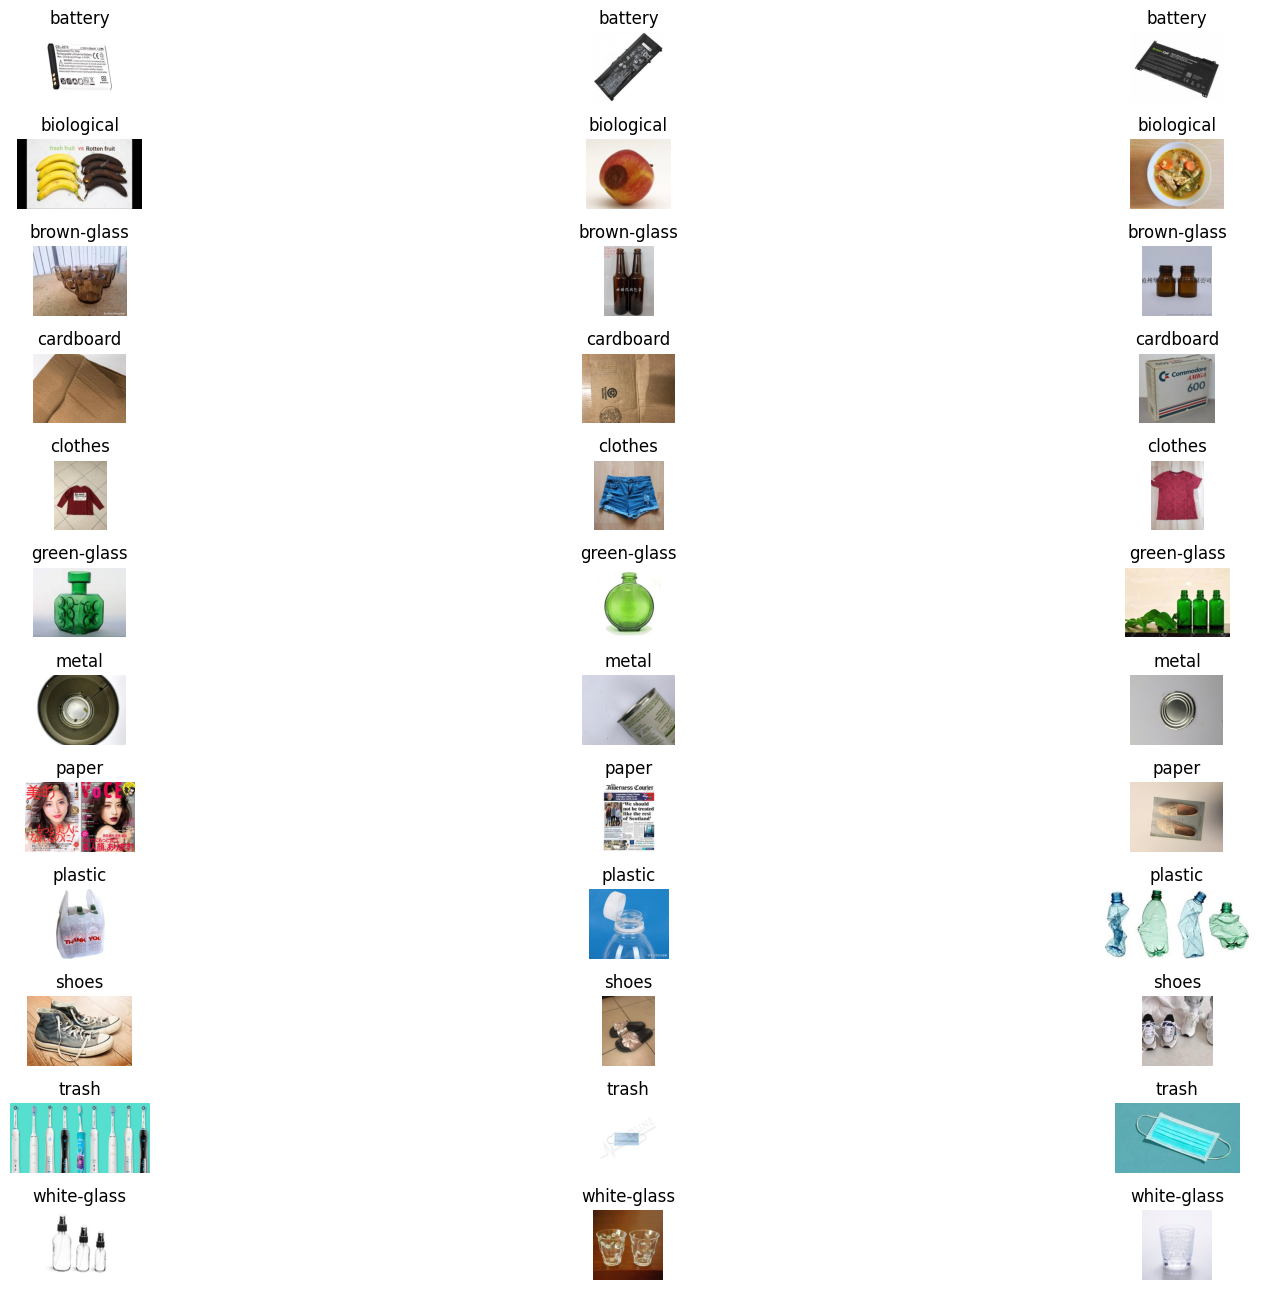

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

num_images_per_class = 3

plt.figure(figsize=(20, 13))
plot_index = 1

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)[:num_images_per_class]

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path)

        plt.subplot(len(class_names), num_images_per_class, plot_index)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
        plot_index += 1

plt.tight_layout()
plt.show()


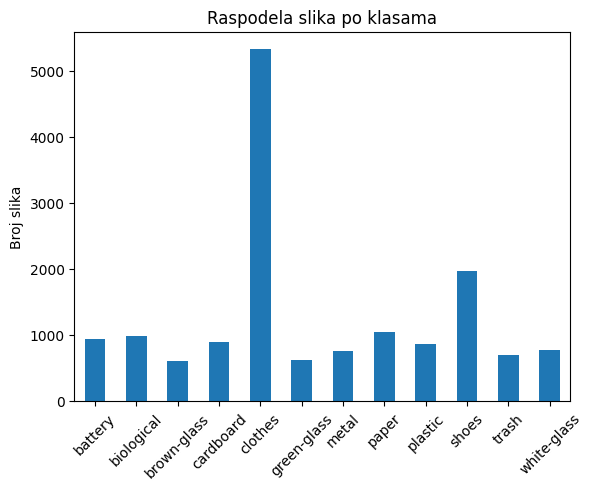

In [ ]:
import pandas as pd

df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Broj slika'])

df_counts.plot(kind='bar', legend=False)
plt.ylabel("Broj slika")
plt.title("Raspodela slika po klasama")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.3684964726631392), 1: np.float64(1.3129230118443316), 2: np.float64(2.128772290809328), 3: np.float64(1.451028517999065), 4: np.float64(0.24285993740219092), 5: np.float64(2.052744708994709), 6: np.float64(1.6795183982683983), 7: np.float64(1.2316468253968254), 8: np.float64(1.4950626204238922), 9: np.float64(0.6539717656974294), 10: np.float64(1.8540919952210275), 11: np.float64(1.6686827956989247)}


Kako bi se ublažio uticaj nebalansirane raspodele klasa u skupu podataka, primenjen je težinski pristup tokom treniranja modela. Težine klasa su izračunate korišćenjem funkcije compute_class_weight iz biblioteke scikit-learn, pri čemu je korišćen režim balanced, koji automatski dodeljuje veće težine klasama sa manjim brojem uzoraka, a manje težine klasama koje su dominantne u skupu podataka. Izračunavanje težina zasniva se na stvarnoj raspodeli oznaka u trening skupu, čime se obezbeđuje da greške na retkim klasama imaju veći uticaj na funkciju gubitka tokom treniranja. Dobijene težine su zatim mapirane u rečnik u formatu koji je kompatibilan sa Keras metodom model.fit. Na ovaj način model se podstiče da posveti jednaku pažnju svim klasama, što doprinosi poboljšanju performansi na slabije zastupljenim klasama.

##4. Baseline model i evaluacija

U ovom koraku definisan je jednostavan konvolucioni neuronski model (CNN) kao baseline rešenje. Model se sastoji od tri konvoluciona sloja koji uče različite nivoe karakteristika slike tj. obrasce, praćene MaxPooling slojevima koji smanjuju dimenzije i broj parametara. Nakon toga, Flatten sloj pretvara izlaz u vektor, koji se prosleđuje u potpuno povezani (Dense) sloj. Dropout sloj je dodat kako bi se smanjio overfitting. Na kraju, izlazni sloj sa softmax aktivacijom daje verovatnoću pripadnosti slici svakoj klasi. Model je kompajliran korišćenjem Adam optimizatora i kategorijske unakrsne entropije, što je standardan pristup za višeklasnu klasifikaciju slika.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), # Use Input layer for explicit input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,508 (42.61 MB)

 Trainable params: 11,170,508 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    class_weight=class_weights,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 202s 499ms/step - accuracy: 0.2832 - loss: 2.2817 - val_accuracy: 0.4390 - val_loss: 1.6488
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 181s 468ms/step - accuracy: 0.4850 - loss: 1.5802 - val_accuracy: 0.5581 - val_loss: 1.3165
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 200s 463ms/step - accuracy: 0.5403 - loss: 1.3983 - val_accuracy: 0.5535 - val_loss: 1.3366
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 181s 467ms/step - accuracy: 0.5640 - loss: 1.3021 - val_accuracy: 0.5984 - val_loss: 1.2336
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 182s 469ms/step - accuracy: 0.5878 - loss: 1.2535 - val_accuracy: 0.6084 - val_loss: 1.1712
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 182s 468ms/step - accuracy: 0.5967 - loss: 1.2170 - val_accuracy: 0.6206 - val_loss: 1.1697
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 181s 466ms/step - accuracy: 0.6042 - loss: 1.2073 - val_accuracy: 0.6071 - val_loss: 1.1646
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 181s 467ms/step - accuracy: 0.6269 -

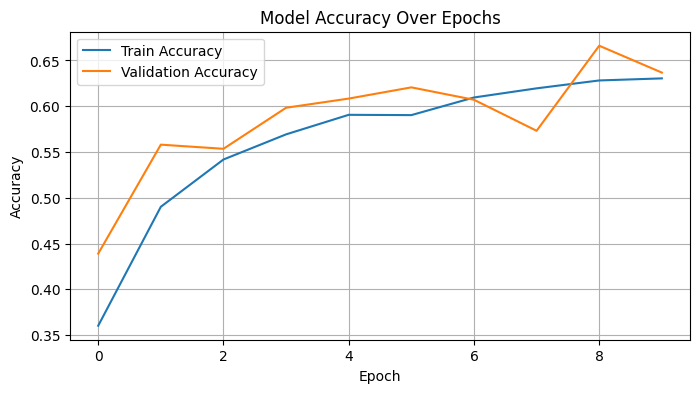

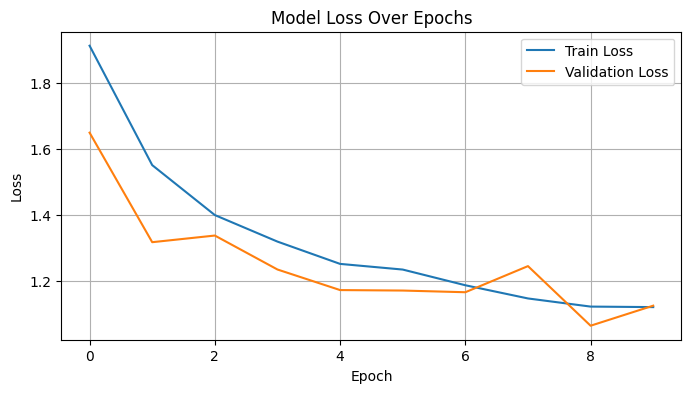

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

###Evaluacija modela (Overall Accuracy, Macro F1-score, Confusion Matrix)

97/97 ━━━━━━━━━━━━━━━━━━━━ 35s 360ms/step
--- Evaluacija Modela ---

Izveštaj o klasifikaciji (Classification Report):

              precision    recall  f1-score   support

     battery       0.57      0.57      0.57       189
  biological       0.56      0.68      0.61       197
 brown-glass       0.62      0.75      0.68       121
   cardboard       0.59      0.71      0.64       178
     clothes       0.93      0.72      0.81      1065
 green-glass       0.74      0.79      0.77       125
       metal       0.36      0.30      0.33       153
       paper       0.40      0.83      0.54       210
     plastic       0.46      0.52      0.49       173
       shoes       0.62      0.51      0.56       395
       trash       0.75      0.73      0.74       139
 white-glass       0.38      0.32      0.35       155

    accuracy                           0.64      3100
   macro avg       0.58      0.62      0.59      3100
weighted avg       0.68      0.64      0.65      3100


Ukupna tačno

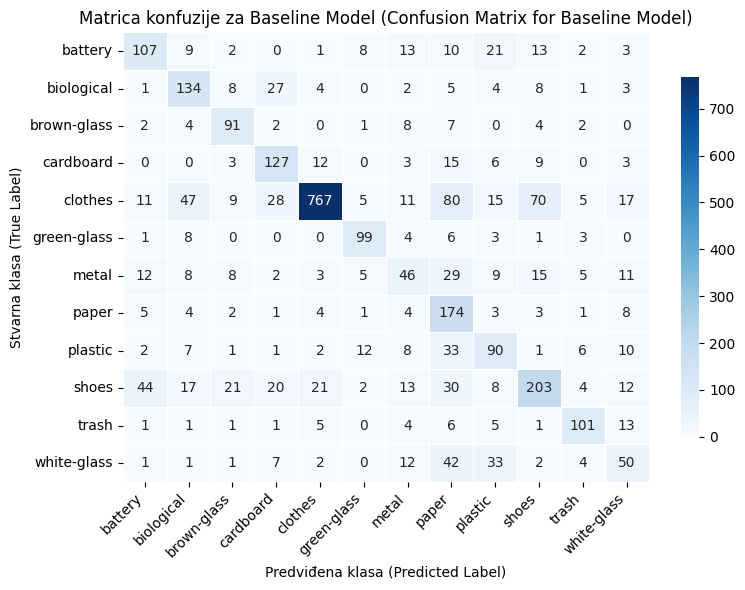

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels from the validation generator
# Reset the generator to ensure order and avoid issues if it was partially consumed
validation_generator.reset()
y_true = validation_generator.classes
# Get class labels in the order used by the generator
class_labels = list(validation_generator.class_indices.keys())

# Predict probabilities for the validation set
# `model.predict` will iterate through the entire validation_generator
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("--- Evaluacija Modela ---")

# 1. Classification Report (Accuracy, Precision, Recall, F1-score)
print("\nIzveštaj o klasifikaciji (Classification Report):\n")
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# 2. Overall Accuracy (already in the report, but good to highlight)
overall_accuracy = (y_true == y_pred).mean()
print(f"\nUkupna tačnost (Overall Accuracy): {overall_accuracy:.4f}")

# 3. F1 Score (macro average for overall performance)
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Makro F1-skor (Macro F1-score): {macro_f1:.4f}")

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nMatrica konfuzije (Confusion Matrix):\n")
print(cm)

# Plot confusion matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=.5, cbar_kws={"shrink": .8})
plt.xlabel('Predviđena klasa (Predicted Label)')
plt.ylabel('Stvarna klasa (True Label)')
plt.title('Matrica konfuzije za Baseline Model (Confusion Matrix for Baseline Model)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



##5. Zaključak


U okviru ove kontrolne tačke uspešno je analiziran skup podataka za klasifikaciju otpada, sprovedeno osnovno pretprocesiranje, primenjena augmentacija i izgrađen baseline CNN model.

Analiza podataka je pokazala postojanje 12 klasa, ali i značajnu nebalansiranost skupa, što je uticalo na performanse modela. Pretprocesiranje je obuhvatilo promenu dimenzija slika na 224×224 piksela i normalizaciju piksela na opseg [0,1], što je omogućilo konzistentan ulaz u neuronsku mrežu i stabilnije treniranje. Dodatno, u trening procesu primenjena je augmentacija (rotacija, pomeranje, zumiranje i horizontalno okretanje), kako bi se povećala raznovrsnost podataka i smanjila prekomerna prilagodljivost modela na specifične uzorke. Zbog nebalansiranosti klasa, tokom treniranja je korišćen i pristup težinskih faktora (class weights), kojim su slabije zastupljenim klasama dodeljene veće težine, čime se model podstiče da im posveti veću pažnju.

Baseline model je uspešno treniran i evaluiran na validacionom skupu, pri čemu je postignuta ukupna tačnost od 64.16% i makro F1-skor 0.5908. Rezultati klasifikacije pokazuju da model prepoznaje obrasce u podacima, što se potvrđuje dominantnim vrednostima na dijagonali matrice konfuzije, kao i relativno visokim vrednostima precision i recall za neke klase (npr. clothes, brown-glass, green-glass, trash). Međutim, uočene su slabije performanse za određene klase, posebno one sa manjim brojem uzoraka (npr. metal, white-glass, paper), što je posledica nebalansiranosti podataka i sličnosti objekata unutar pojedinih klasa. Confusion matrix dodatno ukazuje na parove klasa koje se često mešaju, što daje smernice za buduća poboljšanja.

U narednim fazama rada potrebno je dodatno raditi na balansiranju dataset-a, unapređenju augmentacije kao i primeni naprednijih modela (npr. transfer learning), kako bi se poboljšale performanse, posebno za klase sa slabijom tačnošću.